## IMPORTING PACKAGES

In [38]:
# %pip install openpyxl --upgrade
import pandas as pd
import numpy as np
import seaborn as sns
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## DATA UNDERSTANDING

In [39]:
df_train = pd.read_excel("Assignment_Data/Data.xlsx")

df_train.head()

,Text,Author
0,Scoring in PROC DISCRIM is as easy as validati...,AM
1,"In the GLM procedure, you may have used LSMEAN...",AM
2,"The first problem, accuracy of the data file, ...",AM
3,If the homogeneity of covariance matrices assu...,AM
4,"With a CONTRAST statement, you specify L, in t...",AM


In [40]:
df_train.shape

(1922, 2)

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922 entries, 0 to 1921
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    1922 non-null   object
 1   Author  1922 non-null   object
dtypes: object(2)
memory usage: 30.2+ KB


In [42]:
df_train["length"] = df_train.Text.apply(len)
df_train.head()

,Text,Author,length
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215
1,"In the GLM procedure, you may have used LSMEAN...",AM,782
2,"The first problem, accuracy of the data file, ...",AM,990
3,If the homogeneity of covariance matrices assu...,AM,934
4,"With a CONTRAST statement, you specify L, in t...",AM,1490


Author
CD    690
DM    424
AM    314
TK    228
FE    140
DO    126
Name: count, dtype: int64

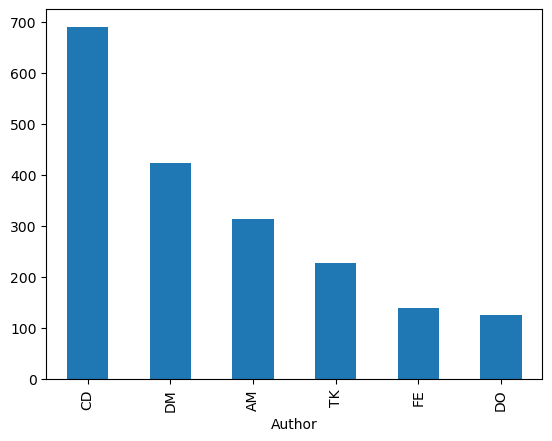

In [43]:
df_train.Author.value_counts().plot(kind="bar")

display(df_train.Author.value_counts())

/Users/daaa/opt/miniconda3/envs/torchenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/daaa/opt/miniconda3/envs/torchenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/daaa/opt/miniconda3/envs/torchenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Author', ylabel='length'>

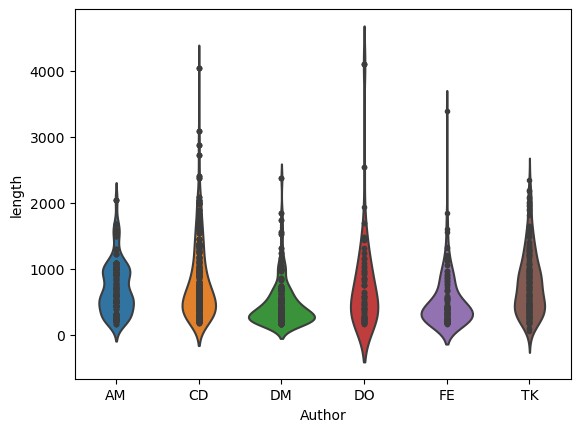

In [55]:
# sns.boxplot(data=df_train, x=df_train.Author, y=df_train.length)
sns.violinplot(data=df_train, x=df_train.Author, y=df_train.length, inner="points")

<div class="alert alert-info" role="alert">
    Presence of outliers indicates that texts which are unusually long or short could indicate the author's sentiment more strongly. The violin plot shows that majority of the text lengths are around 400 - 500 characters.
</div>
<div class="alert alert-info" role="alert">
    Given the differences in the text lengths, it would be best to normalize the text to control the author specific length effects.
</div>

In [57]:
duplicate_data = df_train.duplicated(keep="first")
df_train[duplicate_data].sort_values(by="Text")

,Text,Author,length
1367,"%distribution(data=&data,out=&report_name,cont...",DM,989
1419,"%distribution(data=&data,out=&report_name,cont...",DM,989
1414,"%generate_grouping(from=work.profile_codes,val...",DM,459
1243,"%generate_grouping(from=work.profile_codes,val...",DM,459
1362,*\tTemporal infidelity occurs when model input...,DM,1559
...,...,...,...
129,where Vt = St if using within-group covariance...,AM,433
308,where Vt = St if using within-group covariance...,AM,433
833,where is the diagonal elements of the hat matr...,CD,299
847,where is the diagonal elements of the hat matr...,CD,299


<div class="alert alert-info" role="alert">
    There's quite a lot of duplicated rows present. These will be unhelpful for training the model and need to be removed.
</div>

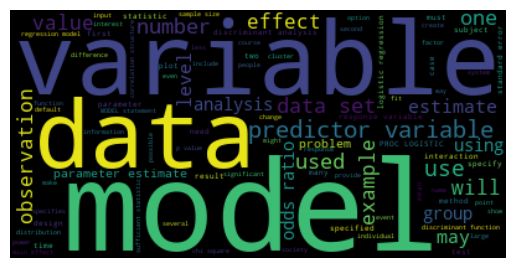

In [58]:
text = " ".join(df_train.Text)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<div class="alert alert-info" role="alert">
At first glance it can be seen that: 
    <br>
    -> Most important words: "Model", "Data", "Analysis", "Variable" <br>
    -> Stopwords: "One", "May", "Even", "Must"
</div>

<Figure size 800x400 with 0 Axes>

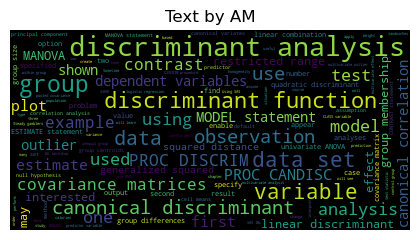

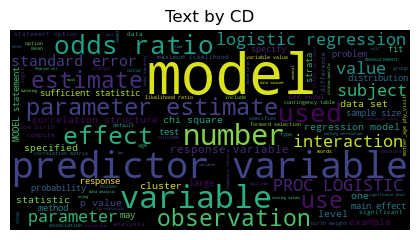

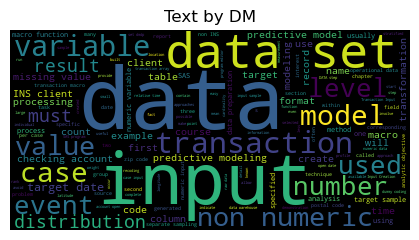

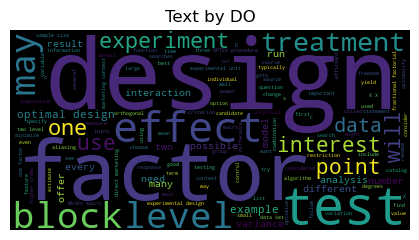

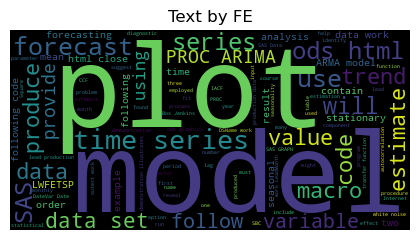

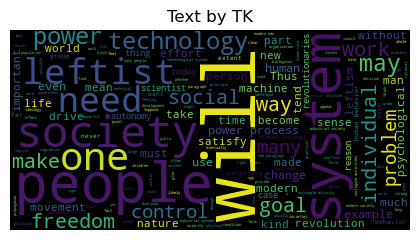

In [89]:
# look at the words that each author has written

author_texts = {author: " ".join(df_train[df_train['Author'] == author]['Text']) for author in df_train.Author.unique()}

fig = plt.figure(figsize = (8,4))


for author, text in author_texts.items():
    wordcloud = WordCloud().generate(text)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.subplot(122)
    plt.imshow(wordcloud) 
    plt.title(f"Text by {author}")
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

<div class="alert alert-info" role="alert">
At first glance it can be seen that each author is speaking about different topics: 
    <br>
    -> AM: talks about statistical classification techniques, discussing things such as discriminant analysis, group differences, and variable selection <br>
    -> CD: talks about machine learning and probability concepts like logistic regression, odds ratios, model estimation, predictor variable <br>
    -> DM: talks about data modeling, specifically addressing the management and analysis of transactional data sets <br>
    -> DO: talks about experimental design and topics like block design and factorial experiements <br>
    -> FE: talks about time series forecasting with topics like PROC, ARMIA and forecast
    -> TK: talks about societal impact, with topics like society, psychological, and people.
</div>

## DATA PREPARATION

<div class="alert alert-info" role="alert">
    Data is imbalanced, need to do a combination of oversampling and undersampling to have equal representation of each class (author) and ensure that our model shows no bias. The reason for using combination of oversampling and undersampling is because making use of just undersampling techniques will reduce the amount of data provided and doing just oversampling will run the risk of overfitting the model, as it might start to "memorize" the oversampled data instead of learning to generalize from patterns in the data.
</div>

In [13]:
def text_preprocessing(txt):
    lemmatiser = WordNetLemmatizer()
    txt_tokens = txt.split(" ")
    txt_lowercase = [word.lower() for word in txt_tokens]
    txt_no_punctuation = [word.translate(str.maketrans('', '', string.punctuation)) for word in txt_lowercase]
    txt_lemmatize = [lemmatiser.lemmatize(word) for word in txt_no_punctuation]
    txt_no_stopwords = [word for word in txt_lemmatize if word not in stopwords.words('english')]
    return txt_no_stopwords

In [14]:
df_train["preprocessed_text"] = df_train["Text"].apply(lambda x: text_preprocessing(x))
df_train.head()

,Text,Author,length,preprocessed_text
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,"[scoring, proc, discrim, easy, validation, spe..."
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,"[glm, procedure, may, used, lsmeans, mean, sta..."
2,"The first problem, accuracy of the data file, ...",AM,990,"[first, problem, accuracy, data, file, problem..."
3,If the homogeneity of covariance matrices assu...,AM,934,"[homogeneity, covariance, matrix, assumption, ..."
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,"[contrast, statement, specify, l, case, vector..."
